# Gaussian Processes as White noise-driven SDEs

See various works by Hartikainen, Solin and Särkkä.

## Import libraries

UndefVarError: UndefVarError: GadFly not defined

In [1]:
using LinearAlgebra
using SparseArrays
using Distributions
using SpecialFunctions
using Plots

 ## Utility Functions
 
 - `lyapchol` : Solving the continuous Lyapunov equation ensuring positive-definiteness
 - `assertposdef!` : Asserts a square matrix is positive-definite, and tries to enforce positive-definiteness if possible
 - `assertparams!` : Asserts parameters exist in dictionary, and sets to default value if not

In [201]:
function lyapchol(A, B, uplo::Symbol=:L)
    """ Solve the Riccati equation AX + XA' + B = 0
            using Cholesky decomposition to ensure positive-definiteness
        Returns triangular matrix representing the cholesky decomposition of X
            By default, this is the lower triangular form, unless uplo=:U
    """
    if size(A,1) == 1
        if size(B,1) == 1
            typeof(A) <: AbstractArray ? A = A[1] : nothing;
            typeof(B) <: AbstractArray ? B = B[1] : nothing;
            X = √(-(B*B) / 2A);
        else
            error("A and B should be the same size");
        end
    else
        X = cholesky(Hermitian(lyap(A, B*B')))
        X = uplo == :U ? X.U : X.L
    end
    return X
end

@inline function assertposdef!(A; report::Bool=false)
    """ Checks positive definiteness of matrix """
    size(A,1) ≠ size(A,2) ? error("Matrix must be square !") : nothing;
    if isposdef(A)
        report ? println("Confirmed that matrix is positive definite.") : nothing;
    elseif isposdef(A + eps()*I)
        report ? println("Matrix was not positive definite, incrementing with ε⋅𝐈") : nothing;
        A += eps()*I;
    else
        report ? println("Matrix was not positive definite, attempting to make positive definite.") : nothing;
        U,S,V = svd(A + eps()*I)
        L = U * Diagonal(sqrt.(S));
        A .= L*L';
        isposdef(A) ? (report ? println("Made matrix positive definite.") : nothing) : error("Could not make matrix positive definite.");
    end
end

function assertparams!(
        θ::Dict,
        keys::Union{Tuple,AbstractArray},
        default::Union{Tuple,AbstractArray};
        alt_names::Union{Missing,Union{Tuple,AbstractArray}}=missing
    )
    """ Checks parameter keys exist and if they don't, assigns them with default values.
            Can provide an optional list of alternative names for keys.
    """
    
    # Check number of keys and number of default parameters is the same
    if length(keys) ≠ length(default)
        error("List of parameter names and list of default values must have the same length!")
    # If alt_names list is provided, make sure if is the same length as keys
    elseif ~ismissing(alt_names) && length(keys) ≠ length(alt_names)
        println("Warning: if providing list of alternative parameter names, it must be same length as keys.")
        println("         Ignoring list of alternative names.");
        # If not, ignore alt_names
        alt_names = missing;
    end
    
    # Check through list of keys in dictionary and assign default value if missing
    for (i,k,d) ∈ zip(1:length(keys), keys, default)
        # If key not present
        if k ∉ Base.keys(θ)
            # Check alternative naming, if provided
            if ~ismissing(alt_names)
                if typeof(alt_names[i]) <: Union{AbstractArray, Tuple}
                    for alt_k ∈ alt_names[i]
                        # Take only first correct alternative name (in case of multiple matching)
                        if alt_k ∈ Base.keys(θ)
                            θ[k] = θ[alt_k];
                            break
                        end
                    end
                    k ∉ Base.keys(θ) ? θ[k] = d : nothing;
                else
                    alt_names[i] ∈ Base.keys(θ) ? θ[k] = θ[alt_names[i]] : θ[k] = d;
                end
            else
                # Assign default value if no alternative name matches
                θ[k] = d;
            end
        end
    end
end

assertparams! (generic function with 1 method)

### Calculate steady-state covariance of system

We obtain the steady-state covariance of 
$$\mathrm{d}\mathbf{x}(t) = \mathbf{F}\mathbf{x}(t)\mathrm{d}t + \mathbf{L}\mathrm{d}\mathbf{\beta}(t)$$
by solving the Riccati equation:
$$
    \frac{\mathrm{d}}{\mathrm{d}t}\mathbf{P} = \mathbf{F}\mathbf{P}_\infty + \mathbf{P}_\infty\mathbf{F}^\mathrm{T} + \mathbf{L}q\mathbf{L}^\mathrm{T} = 0,
$$
where $\mathbf{P}$ is the covariance of the system and $\mathbf{P}_\infty$ is the solution.

In [29]:
function cov_seq_steadystate(𝐅, 𝐋, 𝑞; chol::Bool=false, uplo::Symbol=:L)
    """ Calculate steady state covariance by solving Riccati equation """
    
    if typeof(𝑞) <: AbstractArray 
        return cov_seq_periodic(𝐅, 𝐋, 𝑞, chol=chol, uplo=uplo)
    elseif ~(typeof(𝐅) <: AbstractArray) && isnan(𝐅)
        𝐿 = √𝑞
        return chol ? 𝐿 : 𝐿*𝐿
    else
        𝐿 = lyapchol(𝐅, 𝐋*√𝑞, uplo);
        return chol ? 𝐿 : uplo == :U ? 𝐿'*𝐿 : 𝐿*𝐿'
    end
end

function cov_seq_periodic(𝐅, 𝐋, 𝑞; chol::Bool=false, uplo::Symbol=:L)
    P = chol ? blockdiag(map(a -> sqrt.(a), 𝑞)...) : blockdiag(𝑞...)
    return issparse(𝐅) ? P : Matrix(P)
end

cov_seq_periodic (generic function with 1 method)

### Sample a kernel sequentially

In [110]:
function sample_seq_kernel(
        t::AbstractArray;
        k::Function=kern_seq_matern,
        θ::Union{Dict,Missing}=missing
    )
    """ Sample a given kernel definition sequentially at inputs t"""
    length(t) == 1 ? (return randn(1,1)) : nothing
    
    # Sort t
    t = collect(t);
    sort!(t)
    
    # Get evolutionary matrix components d𝐱 = 𝐅𝐱(t)dt + 𝐋d𝛃 ; f(t) = 𝐇𝐱(t)
    F, L, q, H = k(θ=θ);
    
    # Calculate the steady-state covariance of the system 𝐏∞
    P₀ = cov_seq_steadystate(F, L, q);
    
    # If t is uniformly spaced, only need to discretise once
    uniform_spacing = all((t[2]-t[1]) .≈ (t[2:end] .- t[1:end-1]));
    if uniform_spacing
        # Discretize once: 𝐀 = exp(Δₜ𝐅)
        if typeof(F) <: AbstractArray
            A = exp(F * (t[2]-t[1]));
            # Create positive definite evolutionary covariance
            Q = Hermitian(P₀ - A*P₀*A') |> Matrix; assertposdef!(Q);
        else
            A = isnan(F) ? 0. : exp(F * (t[2]-t[1]))
            Q = P₀ - A*P₀*A'
        end
    end

    # Create variables
    f = zeros(length(t)); # output sample
    μ = typeof(P₀) <: AbstractArray ? rand(MvNormal(P₀)) : P₀ > 0. ? rand(Normal(0., P₀)) : 0.
    #μ = zeros(size(F,1)); # latent state of SDE: μ ≜ 𝐱(tₖ)
    
    for k = 1:length(t)
        # We only need to do this for non-uniform spacing
        if ~uniform_spacing
            # Discretize: 𝐀 = exp(Δₜ𝐅)
            Δ = (k == 1 ? t[2]-t[1] : (t[k]-t[k-1]));
            if typeof(F) <: AbstractArray
                # Create positive definite evolutionary covariance
                A = exp(F * Δ);
                Q = Hermitian(P₀ - A*P₀*A') |> Matrix; assertposdef!(Q);
            else
                A = isnan(F) ? 0. : exp(F * Δ)
                Q = P₀ - A*P₀*A'
            end
        end
        # Propagate evolutionary SDE
        μ = A*μ .+ (typeof(Q) <: AbstractArray ? rand(MvNormal(Q)) : Q > 0. ? rand(Normal(0., Q)) : 0.);
        # Extract sample at tₖ
        f[k] = (H*μ)[1];
    end
    
    return f
end

sample_seq_kernel (generic function with 1 method)

## Combining Kernels



In [218]:
function kern_seq_sum(
        k₁::Function, k₂::Function;
        θ₁::Union{Dict, Missing} = missing,
        θ₂::Union{Dict, Missing} = missing
    )
    """ Sum of two kernels """
    𝐅₁, 𝐋₁, 𝑞₁, 𝐇₁ = k₁(θ=θ₁)
    𝐅₂, 𝐋₂, 𝑞₁, 𝐇₂ = k₂(θ=θ₂)
    
    # Utility function
    blkdiag(A,B) = [A zeros(size(A,1),size(B,2)) ; zeros(size(B,1),size(A,2)) B]
    
    𝐅 = blkdiag(𝐅₁,𝐅₂)
    𝐋 = blkdiag(𝐋₁,𝐋₂)
    𝑞 = [𝑞₁,𝑞₂]
    𝐇 = [𝐇 𝐇]
    
    return 𝐅, 𝐋, 𝑞, 𝐇
end

function kern_seq_prod(
        k₁::Function, k₂::Function;
        θ₁::Union{Dict, Missing} = missing,
        θ₂::Union{Dict, Missing} = missing
    )
    """ Product of two kernels """
    𝐅₁, 𝐋₁, 𝑞₁, 𝐇₁ = k₁(θ=θ₁)
    𝐅₂, 𝐋₂, 𝑞₂, 𝐇₂ = k₂(θ=θ₂)
    
    # Utility function
    ⊗(A,B) = kron(A,B)
    
    𝐅 = (𝐅₁ ⊗ Matrix(I,size(𝐅₁,1),size(𝐅₁,2))) + (Matrix(I,size(𝐅₂,1),size(𝐅₂,2)) ⊗ 𝐅₂)
    𝐋 = 𝐋₁ ⊗ 𝐋₂
    𝑞 = 𝑞₁*𝑞₂
    𝐇 = 𝐇₁ ⊗ 𝐇₂
    
    return 𝐅, 𝐋, 𝑞, 𝐇
end

function kern_seq_periodic_matern(;
        𝐽::Int = 5; # Approximation order
        ν::Union{Missing, Number} = missing, # Matern smoothness
        ω::Union{Missing, Number} = missing, # Frequency
        l::Union{Missing, Number,AbstractArray} = missing, # Length scale
        v::Union{Missing, Number,AbstractArray} = missing, # Variance
        θ::Union{Missing, Dict} = missing  # Dictionary of parameters
    )
    """ """
    
    θ_periodic = deepcopy(θ)
    θ_matern   = deepcopy(θ)
    
    ismissing(l) ? nothing : (θ_periodic[:l], θ_matern[:l]) .= l;
    ismissing(v) ? nothing : (θ_periodic[:v], θ_matern[:v]) .= v;
    if ismissing(l)
        for k ∈ (:l,:ls,:lengthscale,:lengthscales)
            if k ∈ keys(θ)
                (θ_periodic[:l], θ_matern[:l]) = length(θ[:k]) > 1 ? θ[:k] : (θ[:k], θ[:k])
               break
            end
            
        end
    else
        (θ_periodic[:l], θ_matern[:l]) = length(l) > 1 ? l : (l,l);
    end
    if ismissing(v)
        for k ∈ (:variance, :variances, :σ², :scales)
            if k ∈ keys(θ)
                (θ_periodic[:v], θ_matern[:v]) = length(θ[:k]) > 1 ? θ[:k] : (θ[:k], θ[:k])
                break
            end
        end
    else
        (θ_periodic[:v], θ_matern[:v]) = length(v) > 1 ? v : (v,v);
    end
    
    𝐅ᵩ, 𝐋ᵩ, 𝑞ᵩ, 𝐇ᵩ = kern_seq_periodic(𝐽=𝐽, ω=ω, θ=θ_periodic)
    𝐅ₘ, 𝐋ₘ, 𝑞ₘ, 𝐇ₘ = kern_seq_matern(ν=ν, θ=θ_matern)
    
    # Utility function
    ⊗(A,B) = kron(A,B)
    
    𝐅 = (𝐅ₘ ⊗ Matrix(I,size(𝐅ᵩ,1),size(𝐅ᵩ,2))) + (Matrix(I,size(𝐅ₘ,1),size(𝐅ₘ,2)) ⊗ 𝐅ᵩ)
    𝐋 = 𝐋ₘ ⊗ 𝐋ᵩ
    𝑞 = 𝑞₁*𝑞₂
    𝐇 = 𝐇ₘ ⊗ 𝐇ᵩ
    
    return 𝐅, 𝐋, 𝑞, 𝐇
    
end

kern_seq_periodic_matern (generic function with 1 method)

## Kernels definitions

### Matérn
Matérn half-integer covariance functions and exponential kernel.

In [227]:
θ=Dict()
(θ[:a],θ[:b]) = (1.,2.)
θ

Dict{Any,Any} with 2 entries:
  :a => 1.0
  :b => 2.0

In [84]:
function kern_seq_matern(;
        ν::Union{Missing, Number} = missing, # Smoothness
        λ::Union{Missing, Number} = missing, # State space parameter
        l::Union{Missing, Number} = missing, # Length scale
        v::Union{Missing, Number} = missing, # Variance (not to be confused with ν (nu))
        θ::Union{Dict, Missing} = missing,
        _balance::Bool = true)
    """ Sequential version of Matérn half-integer kernel """
    # Fills θ with default parameters
    ismissing(θ) ? θ = Dict{Symbol, Float64}() : nothing;
    assertparams!(θ,
        (:ν, :l, :v), (1.5, 1.0, 1.0),
        alt_names=((:smoothness),(:ls,:lengthscale),(:variance,:σ²))
    )
    # Set values of parameters,
    # : Explicit statement overrides definition in θ
    # : If neither exist, uses default values
    ν = ismissing(ν) ? θ[:ν] : Float64(ν);
    l = ismissing(l) ? θ[:l] : Float64(l);
    v = ismissing(v) ? θ[:v] : Float64(v);
    
    # CHECK UPPER LIMIT ON ν
    ν > 11. ? error("Unable to calculate exact kernel for ν > 10.5.") : nothing
    # TODO: implement approximation method (?)
    
    # Check ν is half-integer
    if floor(Int,ν-0.5) ≠ ν-0.5
        print("ν should be half-integer: rounding to nearest half-integer ⌊ν⌋+0.5");
        ν = floor(ν) + 0.5;
        print(" = "); println(ν)
    end
    
    # State dimensionality
    𝐷 = Int(ν + 0.5);
    # Calculate λ if necessary (alt. set lengthscale based on λ)
    ismissing(λ) ? λ = √(2ν)/l : l = √(2ν)/λ;

    if 𝐷 ≡ 1 # Exponential kernel: ν = ½
        𝐅 = -λ; 𝐋 = 1.; 𝑞 = 2v/l; 𝐇 = 1.;
    else
        # Evolutionary state process
        𝐅 = Bidiagonal(zeros(𝐷), ones(𝐷-1), :U) |> Matrix;
        𝐅[𝐷,:] = -map(𝑖 -> Float64(binomial(𝐷, 𝑖-1)), 1:𝐷) .* λ.^(𝐷:-1:1);
        # White noise evolution
        𝐋 = zeros(𝐷, 1); 𝐋[𝐷] = 1.;
        # Diffusion coefficient
        𝑞 = v*(factorial(𝐷-1)^2 / factorial(2𝐷-2))*(2λ)^(2𝐷-1);
        # Measurement model
        𝐇 = zeros(1, 𝐷); 𝐇[1] = 1.;
        
        if _balance # Rebalances system to avoid overflow
            (_,_,scl) =  LAPACK.gebal!('B',𝐅);
            𝐋  = Diagonal(scl) \ 𝐋;
            𝐇 *= Diagonal(scl);
        end
        
    end
    
    return 𝐅, 𝐋, 𝑞, 𝐇
end

function kern_seq_exponential(;
    l::Union{Missing, Number} = missing, # Length scale
    v::Union{Missing, Number} = missing, # Variance (not to be confused with ν (nu))
    θ::Union{Dict, Missing}   = missing
    )
    """ Sequential version of exponential kernel """
    return kern_seq_matern(ν=0.5, l=l, v=v, θ=θ, _balance=false); 
end

kern_seq_exponential (generic function with 1 method)

### Periodic

In [85]:
function kern_seq_periodic(
    𝐽::Int = 5; # Approximation order
    ω::Union{Missing, Number} = missing, # Frequency
    l::Union{Missing, Number} = missing, # Length scale
    v::Union{Missing, Number} = missing, # Variance
    θ::Union{Missing, Dict}   = missing  # Dictionary of parameters
    )
    """ Sequential approximation of canonical periodic kernel """
    # Fills θ with default parameters
    ismissing(θ) ? θ = Dict{Symbol, Float64}() : nothing;
    assertparams!(θ,
        (:ω, :l, :v, :𝐽, :sparse), (1.0, 1.0, 1.0, 𝐽, 0.0),
        alt_names=((:frequency,:period),(:ls,:lengthscale),(:variance,:σ²),(:limit,:order),())
    )
    # Set values of parameters,
    # : Explicit statement overrides definition in θ
    # : If neither exist, uses default values
    ω = ismissing(ω) ? θ[:ω] : Float64(ω);
    l = ismissing(l) ? θ[:l] : Float64(l);
    v = ismissing(v) ? θ[:v] : Float64(v);
    # Overwrite default 𝐽 with value from θ if present
    𝐽 == 5 ? 𝐽 = Int(θ[:𝐽]) : nothing;
    
    F = Array{SparseMatrixCSC}(undef,𝐽+1)
    L = Array{SparseMatrixCSC}(undef,𝐽+1)
    H = Array{SparseMatrixCSC}(undef,𝐽+1)
    𝑞 = Array{SparseMatrixCSC}(undef,𝐽+1)

    l⁻² = 1.0/(l^2); expl⁻² = exp(l⁻²)
    for j ∈ 0:𝐽
        F[j+1] = sparse([1,2],[2,1],[-ω*j,ω*j],2,2);
        L[j+1] = sparse(I,2,2);
        H[j+1] = sparse([1],[1],[1],1,2);
        
        𝑞ⱼ = besseli(j, l⁻²) / expl⁻²
        𝑞[j+1] = (j > 0 ? 2𝑞ⱼ : 𝑞ⱼ).*sparse(I,2,2);
    end
    
    𝐅 = blockdiag(F...)
    𝐋 = blockdiag(L...)
    𝐇 = cat(H..., dims=2)
    
    if θ[:sparse] == 1
        return 𝐅, 𝐋, 𝑞, 𝐇
    else
        return Matrix(𝐅), Matrix(𝐋), 𝑞, Matrix(𝐇)
    end
end

kern_seq_periodic (generic function with 2 methods)

### White

In [199]:
function kern_seq_white(;
    v::Union{Missing, Number} = missing, # Variance
    θ::Union{Missing, Dict}   = missing  # Dictionary of parameters
    )
    """ White noise kernel """
    ismissing(θ) ? θ = Dict{Symbol, Float64}() : nothing;
    assertparams!(θ,
        [:v], [1.0],
        alt_names=[(:variance,:σ²)]
    )
    # Set values of parameters,
    # : Explicit statement overrides definition in θ
    # : If neither exist, uses default values
    v = ismissing(v) ? θ[:v] : Float64(v);
    
    # White noise parameters
    𝐅 = NaN; 𝐋 = 1; 𝑞 = v; 𝐇 = 1;
    
    return 𝐅, 𝐋, 𝑞, 𝐇
end

function kern_seq_brownian(; # THIS IS WRONG (?)
    v::Union{Missing, Number} = missing, # Variance
    θ::Union{Missing, Dict}   = missing  # Dictionary of parameters
    )
    """ White noise kernel """
    ismissing(θ) ? θ = Dict{Symbol, Float64}() : nothing;
    assertparams!(θ,
        [:v], [1.0],
        alt_names=[(:variance,:σ²)]
    )
    # Set values of parameters,
    # : Explicit statement overrides definition in θ
    # : If neither exist, uses default values
    v = ismissing(v) ? θ[:v] : Float64(v);
    
    # White noise parameters
    𝐅 = -v; 𝐋 = 1.; 𝑞 = 1.; 𝐇 = 1.;
    
    return 𝐅, 𝐋, 𝑞, 𝐇
end



kern_seq_brownian (generic function with 1 method)

## Examples

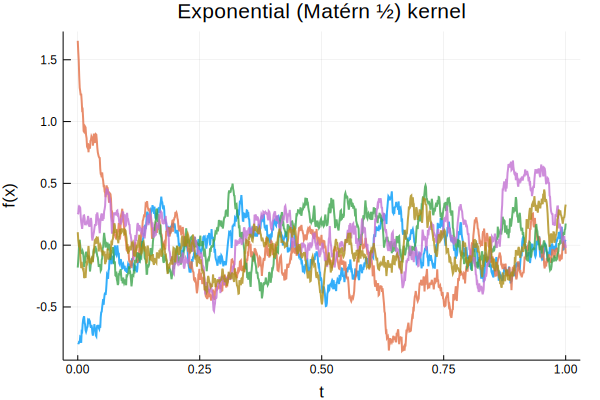

In [102]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Exponential (Matérn ½) kernel")
for _ ∈ 1:n 
    f = sample_seq_kernel(t, k=kern_seq_exponential, θ=Dict(:lengthscale=>0.05));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

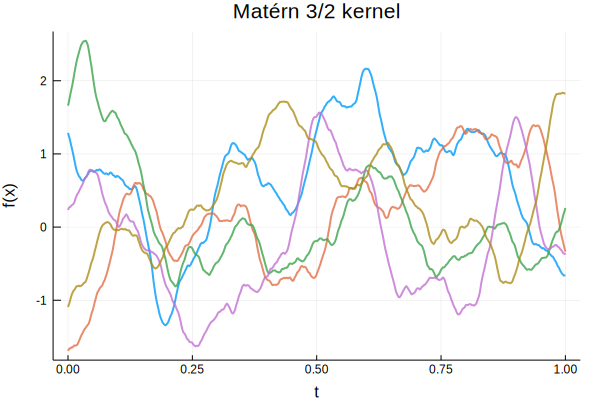

In [103]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Matérn 3/2 kernel")
for _ ∈ 1:n 
    f = sample_seq_kernel(t, k=kern_seq_matern, θ=Dict(:ν=>1.5, :lengthscale=>0.1));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

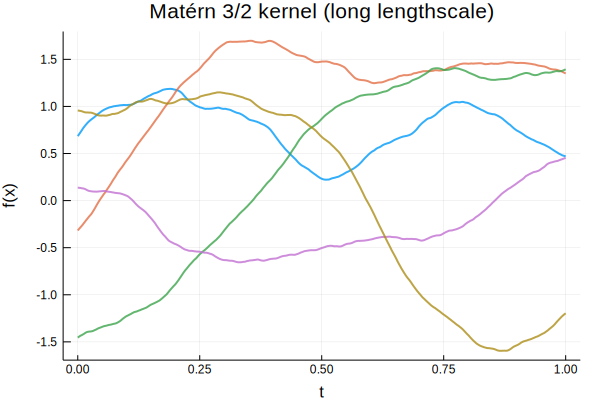

In [104]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Matérn 3/2 kernel (long lengthscale)")
for _ ∈ 1:n 
    f = sample_seq_kernel(t, k=kern_seq_matern, θ=Dict(:ν=>1.5, :lengthscale=>0.5));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

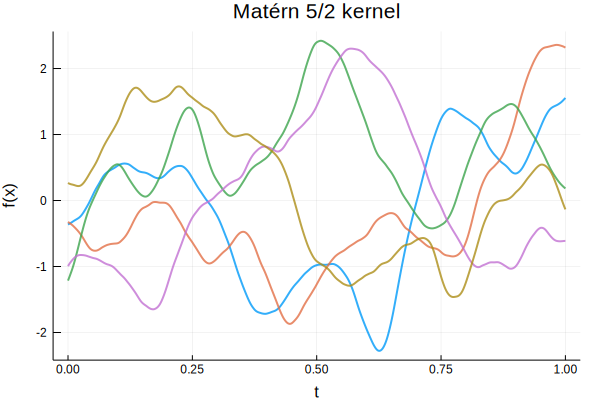

In [105]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Matérn 5/2 kernel")
for _ ∈ 1:n 
    f = sample_seq_kernel(t, k=kern_seq_matern, θ=Dict(:ν=>2.5, :lengthscale=>0.1));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

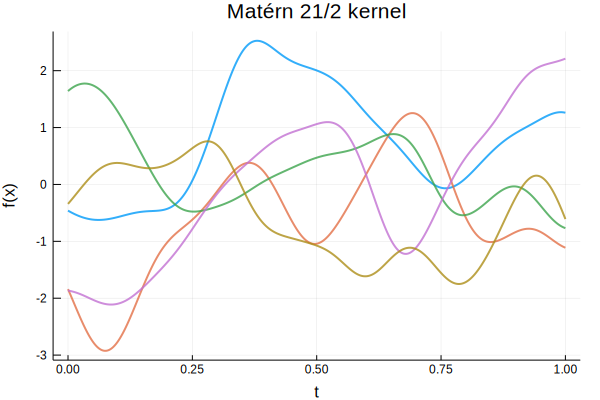

In [106]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Matérn 21/2 kernel")
for _ ∈ 1:n 
    f = sample_seq_kernel(t, k=kern_seq_matern, θ=Dict(:ν=>10.5, :lengthscale=>0.1));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

### Periodic

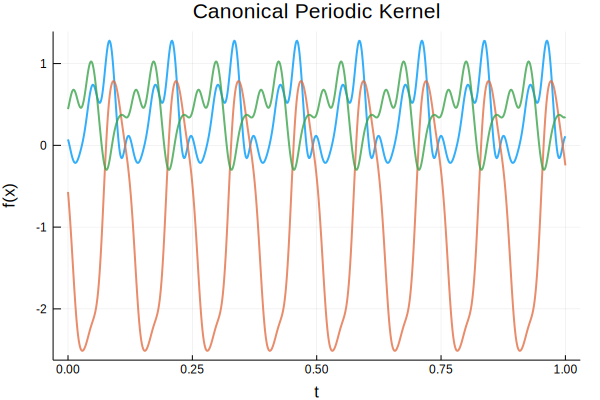

In [107]:
t = LinRange(0.,1.,1000)

n = 3;
p = plot(legend=:none, title="Canonical Periodic Kernel")
for _ ∈ 1:n 
    f = sample_seq_kernel(t, k=kern_seq_periodic, θ=Dict(:period=>50.,:lengthscale=>1.0, :order=>8));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

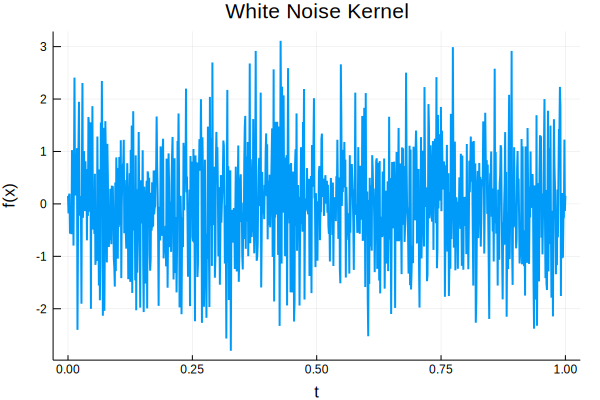

In [108]:
t = LinRange(0.,1.,1000)

n = 1;
p = plot(legend=:none, title="White Noise Kernel")
for _ ∈ 1:n 
    f = sample_seq_kernel(t, k=kern_seq_white, θ=Dict(:variance=>1.));
    plot!(t,f, lw=2, alpha=1.0)
end
xlabel!("t"); ylabel!("f(x)")

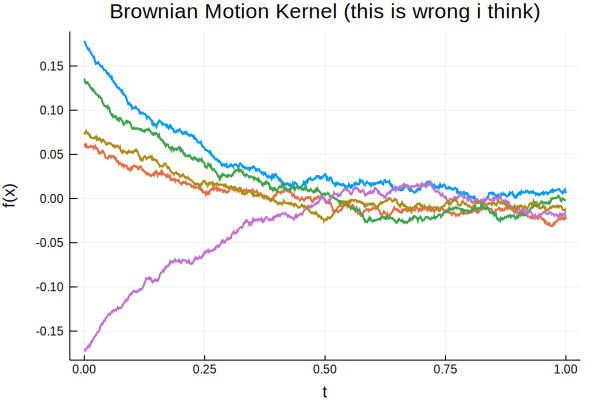

In [200]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Brownian Motion Kernel (this is wrong i think)")
for _ ∈ 1:n
    f = sample_seq_kernel(t, k=kern_seq_brownian, θ=Dict(:variance=>5.));
    plot!(t,f, lw=2, alpha=1.0)
end
xlabel!("t"); ylabel!("f(x)")